First create a direct access to /datasets folder in your personal drive

In [ ]:
# Mount drive if needed
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive



## Install dependencies

In [ ]:
! pip install SimpleITK
! pip install antspyx


## Load images to current session

In [ ]:
! mkdir -v data
! unzip "/content/drive/MyDrive/integradora_fiec/datasets/NATIVE_FILTERED_MANUALLY.zip" -d "/data"

## Define Train Model (CLCI net)

In [ ]:
from keras import *
from keras.layers import *
import tensorflow as tf
kernel_regularizer = regularizers.l2(1e-5)
bias_regularizer = regularizers.l2(1e-5)
kernel_regularizer = None
bias_regularizer = None

def conv_lstm(input1, input2, channel=256):
    """
    Convolutional LSTM layer for processing two inputs.

    Args:
        input1 (tf.Tensor): The first input tensor.
        input2 (tf.Tensor): The second input tensor.
        channel (int, optional): Number of output channels in the ConvLSTM layer. Default is 256.

    Returns:
        tf.Tensor: The output tensor after passing through the ConvLSTM layer.

    """
    lstm_input1 = Reshape((1, input1.shape.as_list()[1], input1.shape.as_list()[2], input1.shape.as_list()[3]))(input1)
    lstm_input2 = Reshape((1, input2.shape.as_list()[1], input2.shape.as_list()[2], input1.shape.as_list()[3]))(input2)

    lstm_input = custom_concat(axis=1)([lstm_input1, lstm_input2])
    x = ConvLSTM2D(channel, (3, 3), strides=(1, 1), padding='same', kernel_initializer='he_normal', kernel_regularizer=kernel_regularizer)(lstm_input)
    return x

def conv_2(inputs, filter_num, kernel_size=(3,3), strides=(1,1), kernel_initializer='glorot_uniform', kernel_regularizer = kernel_regularizer):
    """
    Double convolution block with BatchNormalization and ReLU activation.

    Args:
        inputs (tf.Tensor): The input tensor to the block.
        filter_num (int): Number of filters in the convolutional layers.
        kernel_size (tuple, optional): Size of the convolutional kernel. Default is (3, 3).
        strides (tuple, optional): Strides for the convolution. Default is (1, 1).
        kernel_initializer (str, optional): Initialization method for the convolutional kernel. Default is 'glorot_uniform'.
        kernel_regularizer (tf.keras.regularizers.Regularizer, optional): Regularizer for the convolutional kernel. Default is kernel_regularizer.

    Returns:
        tf.Tensor: The output tensor after passing through the double convolution block.

    """
    conv_ = Conv2D(filter_num, kernel_size=kernel_size, strides=strides, padding='same', kernel_initializer=kernel_initializer, kernel_regularizer = kernel_regularizer)(inputs)
    conv_ = BatchNormalization()(conv_)
    conv_ = Activation('relu')(conv_)
    conv_ = Conv2D(filter_num, kernel_size=kernel_size, strides=strides, padding='same', kernel_initializer=kernel_initializer, kernel_regularizer = kernel_regularizer)(conv_)
    conv_ = BatchNormalization()(conv_)
    conv_ = Activation('relu')(conv_)   
    return conv_

def conv_2_init(inputs, filter_num, kernel_size=(3,3), strides=(1,1)):
    """
    Double convolution block with specific initialization and default regularizer.

    Args:
        inputs (tf.Tensor): The input tensor to the block.
        filter_num (int): Number of filters in the convolutional layers.
        kernel_size (tuple, optional): Size of the convolutional kernel. Default is (3, 3).
        strides (tuple, optional): Strides for the convolution. Default is (1, 1).

    Returns:
        tf.Tensor: The output tensor after passing through the double convolution block with specific initialization.

    """
    return conv_2(inputs, filter_num, kernel_size=kernel_size, strides=strides, kernel_initializer='he_normal', kernel_regularizer = kernel_regularizer) 

def conv_2_init_regularization(inputs, filter_num, kernel_size=(3,3), strides=(1,1)):
    """
    Double convolution block with specific initialization and L2 regularization.

    Args:
        inputs (tf.Tensor): The input tensor to the block.
        filter_num (int): Number of filters in the convolutional layers.
        kernel_size (tuple, optional): Size of the convolutional kernel. Default is (3, 3).
        strides (tuple, optional): Strides for the convolution. Default is (1, 1).

    Returns:
        tf.Tensor: The output tensor after passing through the double convolution block with specific initialization and L2 regularization.

    """
    return conv_2(inputs, filter_num, kernel_size=kernel_size, strides=strides, kernel_initializer='he_normal', kernel_regularizer = regularizers.l2(5e-4)) 

def conv_1(inputs, filter_num, kernel_size=(3,3), strides=(1,1), kernel_initializer='glorot_uniform', kernel_regularizer = kernel_regularizer):
    """
    Single convolution block with optional initialization and regularization.

    Args:
        inputs (tf.Tensor): The input tensor to the block.
        filter_num (int): Number of filters in the convolutional layer.
        kernel_size (tuple, optional): Size of the convolutional kernel. Default is (3, 3).
        strides (tuple, optional): Strides for the convolution. Default is (1, 1).
        kernel_initializer (str, optional): Type of initializer for the convolutional kernel. Default is 'glorot_uniform'.
        kernel_regularizer (tf.keras.regularizers.Regularizer, optional): Regularizer for the convolutional kernel. Default is None.

    Returns:
        tf.Tensor: The output tensor after passing through the single convolution block.

    """
    conv_ = Conv2D(filter_num, kernel_size=kernel_size, strides=strides, padding='same', kernel_initializer=kernel_initializer, kernel_regularizer = kernel_regularizer)(inputs)
    conv_ = BatchNormalization()(conv_)
    conv_ = Activation('relu')(conv_)
    return conv_

def conv_1_init(inputs, filter_num, kernel_size=(3,3), strides=(1,1)):
    """
    Single convolution block with He normal initialization and optional regularization.

    Args:
        inputs (tf.Tensor): The input tensor to the block.
        filter_num (int): Number of filters in the convolutional layer.
        kernel_size (tuple, optional): Size of the convolutional kernel. Default is (3, 3).
        strides (tuple, optional): Strides for the convolution. Default is (1, 1).

    Returns:
        tf.Tensor: The output tensor after passing through the single convolution block with He normal initialization.

    """
    return conv_1(inputs, filter_num, kernel_size=kernel_size, strides=strides, kernel_initializer='he_normal', kernel_regularizer = kernel_regularizer) 

def conv_1_init_regularization(inputs, filter_num, kernel_size=(3,3), strides=(1,1)):
    """
    Single convolution block with He normal initialization and L2 regularization.

    Args:
        inputs (tf.Tensor): The input tensor to the block.
        filter_num (int): Number of filters in the convolutional layer.
        kernel_size (tuple, optional): Size of the convolutional kernel. Default is (3, 3).
        strides (tuple, optional): Strides for the convolution. Default is (1, 1).

    Returns:
        tf.Tensor: The output tensor after passing through the single convolution block with He normal initialization and L2 regularization.

    """
    return conv_1(inputs, filter_num, kernel_size=kernel_size, strides=strides, kernel_initializer='he_normal', kernel_regularizer = regularizers.l2(5e-4))

def dilate_conv(inputs, filter_num, dilation_rate):
    """
    Dilated convolution block with He normal initialization and L2 regularization.

    Args:
        inputs (tf.Tensor): The input tensor to the block.
        filter_num (int): Number of filters in the convolutional layer.
        dilation_rate (int or tuple): Dilation rate for the convolution. If an int is provided, the same dilation is used in both dimensions.

    Returns:
        tf.Tensor: The output tensor after passing through the dilated convolution block with He normal initialization and L2 regularization.

    """
    conv_ = Conv2D(filter_num, kernel_size=(3,3), dilation_rate=dilation_rate, padding='same', kernel_initializer='he_normal', kernel_regularizer = kernel_regularizer)(inputs)
    conv_ = BatchNormalization()(conv_)
    conv_ = Activation('relu')(conv_)
    return conv_

class custom_concat(Layer):
    """
    Custom Concatenation Layer.

    Args:
        axis (int, optional): The axis along which to concatenate the inputs. Default is -1, which corresponds to the last axis.

    Attributes:
        axis (int): The axis along which to concatenate the inputs.

    Methods:
        __init__(self, axis=-1, **kwargs): Initializes the custom_concat layer.
        build(self, input_shape): Builds the custom_concat layer.
        call(self, x): Executes the custom_concat layer on the input tensor.
        compute_output_shape(self, input_shape): Computes the output shape of the custom_concat layer.

    """
    def __init__(self, axis=-1, **kwargs):
        """
        Initializes the custom_concat layer.

        Args:
            axis (int, optional): The axis along which to concatenate the inputs. Default is -1, which corresponds to the last axis.

        """
        super(custom_concat, self).__init__(**kwargs)
        self.axis = axis

    def build(self, input_shape):
        """
        Builds the custom_concat layer.

        Args:
            input_shape (tuple): The shape of the input tensor.

        """
        # Create a trainable weight variable for this layer.
        self.built = True
        super(custom_concat, self).build(input_shape)  # Be sure to call this somewhere!

    def call(self, x):
        """
        Executes the custom_concat layer on the input tensor.

        Args:
            x (tf.Tensor or list of tf.Tensor): The input tensor or list of input tensors to concatenate.

        Returns:
            tf.Tensor: The concatenated tensor.

        """
        self.res = tf.concat(x, self.axis)

        return self.res

    def compute_output_shape(self, input_shape):
        """
        Computes the output shape of the custom_concat layer.

        Args:
            input_shape (tuple): The shape of the input tensor.

        Returns:
            tuple: The shape of the output tensor.

        """
        
        input_shapes = input_shape
        output_shape = list(input_shapes[0])

        for shape in input_shapes[1:]:
            if output_shape[self.axis] is None or shape[self.axis] is None:
                output_shape[self.axis] = None
                break
            output_shape[self.axis] += shape[self.axis]

        return tuple(output_shape)

class BilinearUpsampling(Layer):
    """
    Bilinear Upsampling Layer.

    Args:
        upsampling (tuple, optional): The upsampling factor as a tuple (height_factor, width_factor). Default is (2, 2).

    Attributes:
        upsampling (tuple): The upsampling factor as a tuple (height_factor, width_factor).

    Methods:
        __init__(self, upsampling=(2, 2), **kwargs): Initializes the BilinearUpsampling layer.
        compute_output_shape(self, input_shape): Computes the output shape of the BilinearUpsampling layer.
        call(self, inputs): Executes the BilinearUpsampling layer on the input tensor.

    """
    def __init__(self, upsampling=(2, 2), **kwargs):
        """
        Initializes the BilinearUpsampling layer.

        Args:
            upsampling (tuple, optional): The upsampling factor as a tuple (height_factor, width_factor). Default is (2, 2).

        """
        super(BilinearUpsampling, self).__init__(**kwargs)       
        self.upsampling = upsampling
        
    def compute_output_shape(self, input_shape):
        """
        Computes the output shape of the BilinearUpsampling layer.

        Args:
            input_shape (tuple): The shape of the input tensor.

        Returns:
            tuple: The shape of the output tensor.

        """
        height = self.upsampling[0] * \
                 input_shape[1] if input_shape[1] is not None else None
        width = self.upsampling[1] * \
                input_shape[2] if input_shape[2] is not None else None
        return (input_shape[0],
                height,
                width,
                input_shape[3])

    def call(self, inputs):
        """
        Executes the BilinearUpsampling layer on the input tensor.

        Args:
            inputs (tf.Tensor): The input tensor to upsample.

        Returns:
            tf.Tensor: The upsampled tensor.

        """
        return tf.image.resize(inputs, (int(inputs.shape[1] * self.upsampling[0]),
                                                   int(inputs.shape[2] * self.upsampling[1])))

def concat_pool(conv, pool, filter_num, strides=(2, 2)):
    """
    Concatenate and Pooling Layer.

    This function performs concatenation and pooling on the input tensors.

    Args:
        conv (tf.Tensor): The convolutional tensor.
        pool (tf.Tensor): The pooling tensor.
        filter_num (int): The number of filters for the convolutional layer.
        strides (tuple, optional): The strides for the convolutional layer. Default is (2, 2).

    Returns:
        tf.Tensor: The concatenated and pooled tensor.

    """
    conv_downsample = Conv2D(filter_num, (3, 3), strides=strides, padding='same', kernel_initializer='he_normal', kernel_regularizer=kernel_regularizer)(conv)
    conv_downsample = BatchNormalization()(conv_downsample)
    conv_downsample = Activation('relu')(conv_downsample)
    concat_pool_ = Concatenate()([conv_downsample, pool])
    return concat_pool_

######################################
from keras.optimizers import Adam
import keras.backend as K
#from custom_layer import *


def dice_coef(y_true, y_pred):
    """
    This function calculates the Dice coefficient, which is a metric commonly used in image segmentation tasks
    to evaluate the similarity between the predicted segmentation and the ground truth.

    Args:
        y_true (tf.Tensor): The ground truth segmentation mask.
        y_pred (tf.Tensor): The predicted segmentation mask.

    Returns:
        tf.Tensor: The Dice coefficient.

    """
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + 1) / (K.sum(y_true_f * y_true_f) + K.sum(y_pred_f * y_pred_f) + 1)

def dice_coef_loss(y_true, y_pred):
    """
    Dice Coefficient Loss Function.

    Args:
        y_true (tf.Tensor): The ground truth segmentation mask.
        y_pred (tf.Tensor): The predicted segmentation mask.

    Returns:
        tf.Tensor: The Dice coefficient loss.

    """
    return 1. - dice_coef(y_true, y_pred)

def CLCI_Net(input_shape=(224, 176, 1), num_class=1):
    """
    Custom CLCI-Net Model.

    This function defines the CLCI-Net architecture, a custom convolutional neural network for image segmentation tasks.

    Args:
        input_shape (tuple, optional): The shape of the input images. Defaults to (224, 176, 1).
        num_class (int, optional): The number of output classes. For binary segmentation, set it to 1. For multi-class
                                   segmentation, set it to the number of classes. Defaults to 1.

    Returns:
        tf.keras.Model: The CLCI-Net model.

    """
    # The row and col of input should be resized or cropped to an integer multiple of 16.
    inputs = Input(shape=input_shape)

    conv1 = conv_2_init(inputs, 32)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    concat_pool11 = concat_pool(conv1, pool1, 32, strides=(2, 2))
    fusion1 = conv_1_init(concat_pool11, 64 * 4, kernel_size=(1, 1))

    conv2 = conv_2_init(fusion1, 64)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    concat_pool12 = concat_pool(conv1, pool2, 64, strides=(4, 4))
    concat_pool22 = concat_pool(conv2, concat_pool12, 64, strides=(2, 2))
    fusion2 = conv_1_init(concat_pool22, 128 * 4, kernel_size=(1, 1))

    conv3 = conv_2_init(fusion2, 128)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    concat_pool13 = concat_pool(conv1, pool3, 128, strides=(8, 8))
    concat_pool23 = concat_pool(conv2, concat_pool13, 128, strides=(4, 4))
    concat_pool33 = concat_pool(conv3, concat_pool23, 128, strides=(2, 2))
    fusion3 = conv_1_init(concat_pool33, 256 * 4, kernel_size=(1, 1))

    conv4 = conv_2_init(fusion3, 256)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)
    concat_pool14 = concat_pool(conv1, pool4, 256, strides=(16, 16))
    concat_pool24 = concat_pool(conv2, concat_pool14, 256, strides=(8, 8))
    concat_pool34 = concat_pool(conv3, concat_pool24, 256, strides=(4, 4))
    concat_pool44 = concat_pool(conv4, concat_pool34, 256, strides=(2, 2))
    fusion4 = conv_1_init(concat_pool44, 512 * 4, kernel_size=(1, 1))

    conv5 = conv_2_init(fusion4, 512)
    conv5 = Dropout(0.5)(conv5)

    clf_aspp = CLF_ASPP(conv5, conv1, conv2, conv3, conv4, input_shape)

    up_conv1 = UpSampling2D(size=(2, 2))(clf_aspp)
    up_conv1 = conv_1_init(up_conv1, 256, kernel_size=(2, 2))
    skip_conv4 = conv_1_init(conv4, 256, kernel_size=(1, 1))
    context_inference1 = conv_lstm(up_conv1, skip_conv4, channel=256)
    conv6 = conv_2_init(context_inference1, 256)

    up_conv2 = UpSampling2D(size=(2, 2))(conv6)
    up_conv2 = conv_1_init(up_conv2, 128, kernel_size=(2, 2))
    skip_conv3 = conv_1_init(conv3, 128, kernel_size=(1, 1))
    context_inference2 = conv_lstm(up_conv2, skip_conv3, channel=128)
    conv7 = conv_2_init(context_inference2, 128)

    up_conv3 = UpSampling2D(size=(2, 2))(conv7)
    up_conv3 = conv_1_init(up_conv3, 64, kernel_size=(2, 2))
    skip_conv2 = conv_1_init(conv2, 64, kernel_size=(1, 1))
    context_inference3 = conv_lstm(up_conv3, skip_conv2, channel=64)
    conv8 = conv_2_init(context_inference3, 64)

    up_conv4 = UpSampling2D(size=(2, 2))(conv8)
    up_conv4 = conv_1_init(up_conv4, 32, kernel_size=(2, 2))
    skip_conv1 = conv_1_init(conv1, 32, kernel_size=(1, 1))
    context_inference4 = conv_lstm(up_conv4, skip_conv1, channel=32)
    conv9 = conv_2_init(context_inference4, 32)


    if num_class == 1:
        conv10 = Conv2D(num_class, (1, 1), activation='sigmoid')(conv9)
    else:
        conv10 = Conv2D(num_class, (1, 1), activation='softmax')(conv9)

    model = Model(inputs=inputs, outputs=conv10)

    return model

def CLF_ASPP(conv5, conv1, conv2, conv3, conv4, input_shape):
    """
    Classifier Atrous Spatial Pyramid Pooling (ASPP) Module.

    This function implements the Classifier ASPP module, which performs atrous spatial pyramid pooling and concatenates
    the outputs from different dilated convolutions along with the intermediate convolutions from previous layers.

    Args:
        conv5 (tf.Tensor): The feature map from the fifth convolutional layer (conv5).
        conv1 (tf.Tensor): The feature map from the first convolutional layer (conv1).
        conv2 (tf.Tensor): The feature map from the second convolutional layer (conv2).
        conv3 (tf.Tensor): The feature map from the third convolutional layer (conv3).
        conv4 (tf.Tensor): The feature map from the fourth convolutional layer (conv4).
        input_shape (tuple): The shape of the input images.

    Returns:
        tf.Tensor: The output tensor after performing Classifier ASPP.

    """
    b0 = conv_1_init(conv5, 256, (1, 1))
    b1 = dilate_conv(conv5, 256, dilation_rate=(2, 2))
    b2 = dilate_conv(conv5, 256, dilation_rate=(4, 4))
    b3 = dilate_conv(conv5, 256, dilation_rate=(6, 6))

    out_shape0 = input_shape[0] // pow(2, 4)
    out_shape1 = input_shape[1] // pow(2, 4)
    b4 = AveragePooling2D(pool_size=(out_shape0, out_shape1))(conv5)
    b4 = conv_1_init(b4, 256, (1, 1))
    b4 = BilinearUpsampling((out_shape0, out_shape1))(b4)

    clf1 = conv_1_init(conv1, 256, strides=(16, 16))
    clf2 = conv_1_init(conv2, 256, strides=(8, 8))
    clf3 = conv_1_init(conv3, 256, strides=(4, 4))
    clf4 = conv_1_init(conv4, 256, strides=(2, 2))

    outs = Concatenate()([clf1, clf2, clf3, clf4, b0, b1, b2, b3, b4])

    outs = conv_1_init(outs, 256 * 4, (1, 1))
    outs = Dropout(0.5)(outs)

    return outs

## Preprocessing steps functions

In [ ]:
import os
import ants
import SimpleITK as sitk

print(f'AntsPy version = {ants.__version__}')
print(f'SimpleITK version = {sitk.__version__}')

AntsPy version = 0.3.8
SimpleITK version = 2.2.1


In [ ]:
mni_T1_path = TEMPLATE_PATH = '/content/drive/MyDrive/integradora_fiec/datasets/templates/mni_icbm152_t1_tal_nlin_sym_09a.nii'

def load_template_ants() -> ants.ANTsImage:
    """
    Load the template image using the ANTs library.

    Returns:
        ants.ANTsImage: The loaded template image as an ANTs image object.

    """
    template_img_ants = ants.image_read(TEMPLATE_PATH)
    return template_img_ants

def load_img_ants(path: str) -> ants.ANTsImage:
    """
    Load an image using ANTs library.

    Args:
        path (str): The path to the image file.

    Returns:
        ants.ANTsImage: The loaded image as an ANTsImage object.
    """
    raw_img_ants = ants.image_read(path)
    return raw_img_ants

def register_to_mni(img: ants.ANTsImage, mask: ants.ANTsImage) -> ants.ANTsImage:
    """
    Register an ANTs MRI image and its mask to the MNI space.

    Args:
        img (ants.ANTsImage): The input MRI image to be registered.
        mask (ants.ANTsImage): The mask corresponding to the MRI image.

    Returns:
        Tuple[ants.ANTsImage, ants.ANTsImage]: A tuple containing the registered MRI image
        and the registered mask, both in the MNI space.
    """
    template_img = load_template_ants()
    transformation = ants.registration(fixed=template_img, moving=img, type_of_transform='SyN')

    img_registered = transformation['warpedmovout']
  
    mask_registered = ants.apply_transforms(fixed=template_img,moving=mask,transformlist=transformation['fwdtransforms'])
    return img_registered, mask_registered

def register_to_mni_single(img: ants.ANTsImage) -> ants.ANTsImage:
    """
    Register an ANTs MRI image to the MNI space.

    Args:
        img (ants.ANTsImage): The input MRI image to be registered.

    Returns:
        ants.ANTsImage: The registered MRI image in the MNI space.
    """
    template_img = load_template_ants()
    transformation = ants.registration(fixed=template_img, moving=img, type_of_transform='SyN')

    img_registered = transformation['warpedmovout']
  
    return img_registered

In [ ]:
def bias_field_correction(img: sitk.Image) -> sitk.Image:
    """
    Perform bias field correction on a given SimpleITK Image.

    Args:
        img (sitk.Image): The input image to be corrected.

    Returns:
        sitk.Image: The bias-corrected image.
    """
    head_mask = sitk.RescaleIntensity(img, 0, 255)
    head_mask = sitk.LiThreshold(head_mask,0,1)
    # Downsample the input image and the head mask by a factor of 4 using shrink
    shrinkFactor = 4
    inputImage = img
    inputImage = sitk.Shrink( img, [ shrinkFactor ] * inputImage.GetDimension() )
    maskImage = sitk.Shrink( head_mask, [ shrinkFactor ] * inputImage.GetDimension() )

    bias_corrector = sitk.N4BiasFieldCorrectionImageFilter()
    bias_corrector.Execute(inputImage, maskImage)

    log_bias_field = bias_corrector.GetLogBiasFieldAsImage(img)
    result = img / sitk.Exp( log_bias_field ) # corrected img at full resolution

    # output of division has 64 pixel type, we cast it to float32 to keep compatibility
    result = sitk.Cast(result, sitk.sitkFloat32)
    
    return result

def load_img_sitk(path: str) -> sitk.Image:
    """
    Load an image using SimpleITK library.

    Args:
        path (str): The path to the image file.

    Returns:
        sitk.Image: The loaded image as a SimpleITK Image object.
    """
    raw_img_sitk = sitk.ReadImage(path, sitk.sitkFloat32)
    return raw_img_sitk

In [ ]:
# load mni152 brain mask
TEMPLATE_BRAIN_MASK_PATH = '/content/drive/MyDrive/integradora_fiec/datasets/templates/mni_icbm152_t1_tal_nlin_sym_09a_mask.nii'
mni152_brain_mask = sitk.ReadImage(TEMPLATE_BRAIN_MASK_PATH, sitk.sitkFloat32)
mni152_T1 = sitk.ReadImage(TEMPLATE_PATH, sitk.sitkFloat32)

In [ ]:
import numpy as np
from typing import Tuple
def preprocess_ximg(ximg: sitk.Image, flipped = False) -> Tuple[np.ndarray, sitk.Image]:
  """
    Preprocess a SimpleITK Image 

    Args:
        ximg (sitk.Image): The input image to be preprocessed.
        flipped (bool, optional): Flag to indicate whether to flip the image or not. Defaults to False.

    Returns:
        Tuple[np.ndarray, sitk.Image]: A tuple containing the preprocessed image as a NumPy array
        and the corresponding preprocessed SimpleITK Image.
    """
  x3d = sitk.HistogramMatching(ximg, mni152_T1)
  x3d = sitk.Multiply(x3d, mni152_brain_mask) # mask brain
  x3d = sitk.CurvatureAnisotropicDiffusion(x3d, conductanceParameter=1, numberOfIterations=1) # denoise a bit
  x3d_sitk_preprocessed = x3d
  
  if flipped:
    x3d = sitk.Flip(x3d,(True, False, False))
  
  x3d = sitk.GetArrayFromImage(x3d)
  x3d = x3d[30:160,4:228,14:190] # crop to size -> (130, 224, 176)
  x3d = x3d / 255.0
  x3d = np.expand_dims(x3d,3) # add channel -> (130, 224, 176, 1)
  assert x3d.shape == (130,224,176,1)
  return x3d, x3d_sitk_preprocessed

def preprocess_yimg(yimg: sitk.Image, flipped=False) -> np.ndarray:
  """
    Preprocesses the input 3D image for the y-label (ground truth).

    Args:
        yimg (sitk.Image): The input 3D image to be preprocessed.
        flipped (bool, optional): Whether to flip the image along the x-axis. Defaults to False.

    Returns:
        np.ndarray: The preprocessed 3D numpy array representing the y-label.

    Raises:
        AssertionError: If the resulting array shape doesn't match the expected shape.
  """
  y3d = yimg

  if flipped:
    y3d = sitk.Flip(y3d,(True, False, False))
  
  y3d = sitk.GetArrayFromImage(y3d)
  y3d = y3d[30:160,4:228,14:190] # crop to size -> (130, 224, 176)
  y3d = y3d / 255.0
  y3d = np.expand_dims(y3d,3) # add channel -> (130, 224, 176, 1)
  assert x3d.shape == (130,224,176,1)
  return y3d


In [ ]:
def postprocess_pred(
    raw_pred: np.ndarray,
    ximg_ref_path: str
  ) -> sitk.Image:
  """
  creates a mri image mask from the prediction, padding is used to fit the dimensions
  of an image standardized with mni152 template
  
  ximg_ref_path: is the path of the mri image to get metadata as reference
  """
  assert raw_pred.shape  == (130,224,176,1)
  
  pred = raw_pred.copy()
  pred = pred > 0.5
  pred = pred[:,:,:,0]*255.0
  pred = np.pad(pred, ((29,30), (3,6), (13, 8)))
  assert pred.shape == (189,233,197)

  output = sitk.GetImageFromArray(pred)    
  output.CopyInformation(sitk.ReadImage(ximg_ref_path, sitk.sitkFloat32))
  return output

## Load model and weights

In [ ]:
model = CLCI_Net()
model.load_weights("/content/drive/MyDrive/integradora_fiec/modelos/clcinet-native-filtered-v2-030-0.888012-0.842044.h5")

## !! Register + BF + preprocess + predict

In [ ]:
from glob import glob
xpaths = sorted(glob(f'/data/NATIVE_FILTERED_MANUALLY/test/*/*/*01.nii.gz') )
ypaths = sorted(glob(f'/data/NATIVE_FILTERED_MANUALLY/test/*/*/*_LesionSmooth.nii.gz'))
assert len(xpaths) == len(ypaths)

In [ ]:
print("Number of samples:", len(xpaths))
for input_path, target_path in zip(xpaths, ypaths):
    print(input_path[-35:], "|", target_path[-48:])

In [ ]:
path_to_save="/content/drive/MyDrive/integradora_fiec/datasets/paper lesions extended/native_processed_masked"

for i,(xpath, ypath) in enumerate(zip(xpaths, ypaths)):
  folder = xpath[:-20]
  file_name = xpath[:-7][-13:]

  # register
  x_registered_path = folder + file_name + '_registered.nii.gz'
  y_registered_path = folder + file_name + '_LesionSmooth_registered.nii.gz'

  x3d = load_img_ants(xpath)
  y3d = load_img_ants(ypath)

  x3d_registered, y3d_registered = register_to_mni(img=x3d,mask=y3d)

  x3d_registered.to_file(x_registered_path)
  y3d_registered.to_file(y_registered_path)

  # bias field correction
  x_out_path = folder + file_name + '_registered_BF.nii.gz'
  x3d = load_img_sitk(x_registered_path)
  x3d_bf_corrected = bias_field_correction(x3d)
  sitk.WriteImage(x3d_bf_corrected, x_out_path)

  # preprocess
  #ximg = sitk.ReadImage(x_out_path, sitk.sitkFloat32)
  ximg = x3d_bf_corrected
  x3d, x3d_sitk_preprocessed = preprocess_ximg(ximg)

  # generate mask
  mask_path = folder + file_name + '_maskGenerated.nii.gz'
  raw_pred = model.predict(x3d,batch_size=8,verbose=1)
  mask = postprocess_pred(raw_pred, x_registered_path)
  sitk.WriteImage(mask, mask_path) 

  #mask
  print(i,mask_path)
  #if i == 0 : break

## Inspect masks generated

### Define helpers

In [ ]:
import matplotlib.pyplot as plt

from ipywidgets import interact
import numpy as np
import SimpleITK as sitk
import cv2

def explore_3D_array(arr: np.ndarray, cmap: str = 'gray'):
  """
  Given a 3D array with shape (Z,X,Y) This function will create an interactive
  widget to check out all the 2D arrays with shape (X,Y) inside the 3D array. 
  The purpose of this function to visual inspect the 2D arrays in the image. 

  Args:
    arr : 3D array with shape (Z,X,Y) that represents the volume of a MRI image
    cmap : Which color map use to plot the slices in matplotlib.pyplot
  """

  def fn(SLICE):
    plt.figure(figsize=(7,7))
    plt.imshow(arr[SLICE, :, :], cmap=cmap)

  interact(fn, SLICE=(0, arr.shape[0]-1))


def explore_3D_array_comparison(arr_before: np.ndarray, arr_after: np.ndarray, cmap: str = 'gray'):
  """
  Given two 3D arrays with shape (Z,X,Y) This function will create an interactive
  widget to check out all the 2D arrays with shape (X,Y) inside the 3D arrays.
  The purpose of this function to visual compare the 2D arrays after some transformation. 

  Args:
    arr_before : 3D array with shape (Z,X,Y) that represents the volume of a MRI image, before any transform
    arr_after : 3D array with shape (Z,X,Y) that represents the volume of a MRI image, after some transform    
    cmap : Which color map use to plot the slices in matplotlib.pyplot
  """

  assert arr_after.shape == arr_before.shape

  def fn(SLICE):
    """
    Visualizes two images side by side for a given slice.

    Args:
        SLICE (int): The slice index to visualize.

    Returns:
        None
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, sharex='col', sharey='row', figsize=(10,10))

    ax1.set_title('Before', fontsize=15)
    ax1.imshow(arr_before[SLICE, :, :], cmap=cmap)

    ax2.set_title('After', fontsize=15)
    ax2.imshow(arr_after[SLICE, :, :], cmap=cmap)

    plt.tight_layout()
  
  interact(fn, SLICE=(0, arr_before.shape[0]-1))


def show_sitk_img_info(img: sitk.Image):
  """
  Given a sitk.Image instance prints the information about the MRI image contained.

  Args:
    img : instance of the sitk.Image to check out
  """
  pixel_type = img.GetPixelIDTypeAsString()
  origin = img.GetOrigin()
  dimensions = img.GetSize()
  spacing = img.GetSpacing()
  direction = img.GetDirection()

  info = {'Pixel Type' : pixel_type, 'Dimensions': dimensions, 'Spacing': spacing, 'Origin': origin,  'Direction' : direction}
  for k,v in info.items():
    print(f' {k} : {v}')


def add_suffix_to_filename(filename: str, suffix:str) -> str:
  """
  Takes a NIfTI filename and appends a suffix.

  Args:
      filename : NIfTI filename
      suffix : suffix to append

  Returns:
      str : filename after append the suffix
  """
  if filename.endswith('.nii'):
      result = filename.replace('.nii', f'_{suffix}.nii')
      return result
  elif filename.endswith('.nii.gz'):
      result = filename.replace('.nii.gz', f'_{suffix}.nii.gz')
      return result
  else:
      raise RuntimeError('filename with unknown extension')


def rescale_linear(array: np.ndarray, new_min: int, new_max: int):
  """
    Rescale the values of an array linearly to a new range.

    Args:
        array (np.ndarray): The input NumPy array to be rescaled.
        new_min (int): The minimum value of the new range.
        new_max (int): The maximum value of the new range.

    Returns:
        np.ndarray: The rescaled array.
    """
  """Rescale an array linearly."""
  minimum, maximum = np.min(array), np.max(array)
  m = (new_max - new_min) / (maximum - minimum)
  b = new_min - m * minimum
  return m * array + b


def explore_3D_array_with_mask_contour(arr: np.ndarray, mask: np.ndarray, thickness: int = 1):
  """
  Given a 3D array with shape (Z,X,Y) This function will create an interactive
  widget to check out all the 2D arrays with shape (X,Y) inside the 3D array. The binary
  mask provided will be used to overlay contours of the region of interest over the 
  array. The purpose of this function is to visual inspect the region delimited by the mask.

  Args:
    arr : 3D array with shape (Z,X,Y) that represents the volume of a MRI image
    mask : binary mask to obtain the region of interest
  """
  assert arr.shape == mask.shape
  
  _arr = rescale_linear(arr,0,1)
  _mask = rescale_linear(mask,0,1)
  _mask = _mask.astype(np.uint8)

  def fn(SLICE):
    """
    Display an image slice with detected contours overlaid.

    Args:
        SLICE (int): The index of the slice to display.

    Returns:
        None
    """
    arr_rgb = cv2.cvtColor(_arr[SLICE, :, :], cv2.COLOR_GRAY2RGB)
    contours, _ = cv2.findContours(_mask[SLICE, :, :], cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    
    arr_with_contours = cv2.drawContours(arr_rgb, contours, -1, (0,1,0), thickness)

    plt.figure(figsize=(7,7))
    plt.imshow(arr_with_contours)

  interact(fn, SLICE=(0, arr.shape[0]-1))


### Load images


In [ ]:
mpaths = sorted(glob(f'/data/NATIVE_FILTERED_MANUALLY/*/*/*/*01_maskGenerated.nii.gz') )
print("Number of samples:", len(mpaths))
for input_path in mpaths:
    #print(input_path[-35:])
    print(input_path)

Number of samples: 1
/data/NATIVE_FILTERED_MANUALLY/test/Lacunar/c0003s0005t01/c0003s0005t01_maskGenerated.nii.gz


In [ ]:
input_path[:-35]

'/data/NATIVE_FILTERED_MANUALLY/test/Lacunar/c0003s0005t01'

In [ ]:
def id_from_path(path):
  """
    Extracts a specific portion from the input path string.

    The function splits the input 'path' string using the forward slash ('/')
    as a delimiter and returns the element at the 5th index (0-based index).

    Args:
        path (str): The input path string.

    Returns:
        str: The portion of the input path obtained from the 5th index.
    """
  return path.split("/")[5]

interactive(children=(IntSlider(value=94, description='SLICE', max=188), Output()), _dom_classes=('widget-inte…

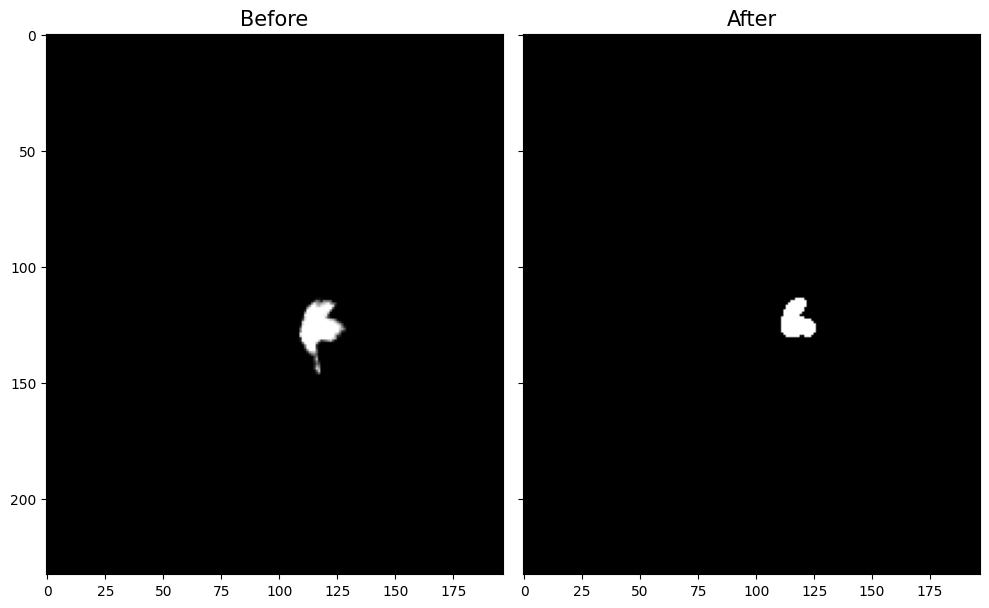

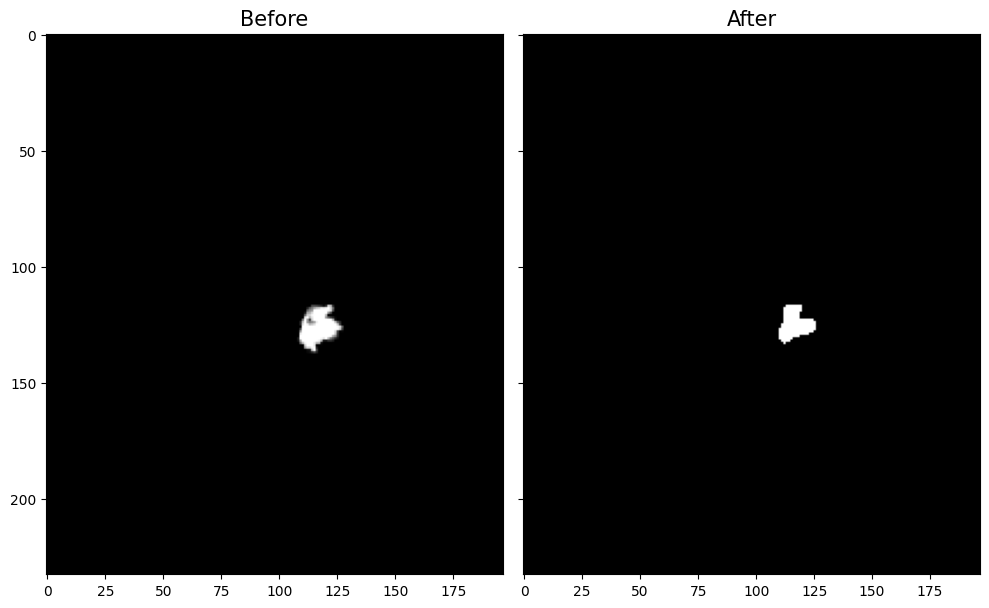

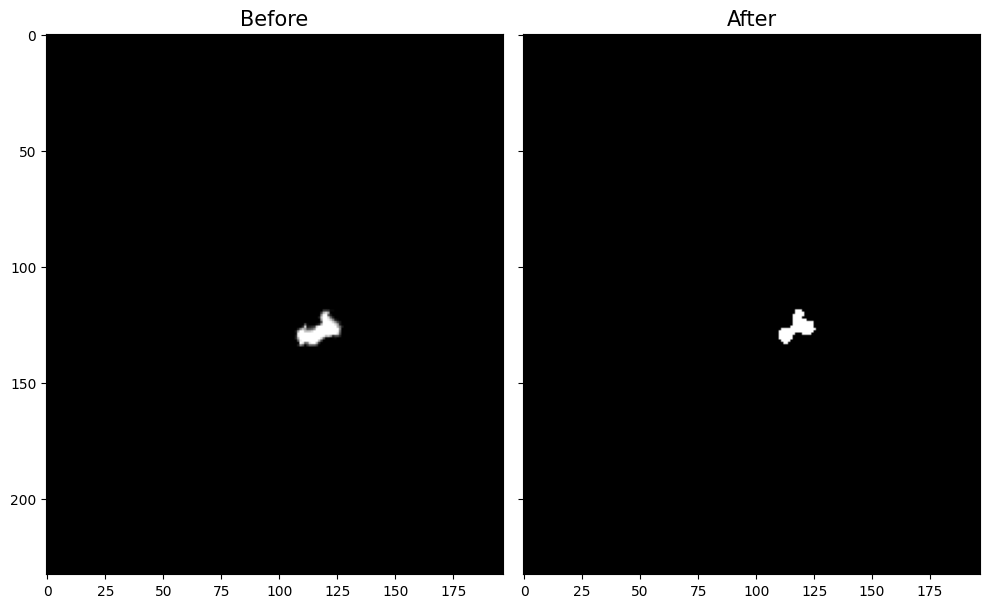

In [ ]:
# compare mask
i = 0
example = mpaths[i][:-35]

test_xpath = example+'/'+id_from_path(example)+'.nii.gz'
test_ypath = example+'/'+id_from_path(example)+'_LesionSmooth_registered.nii.gz'

test_mask =  example+'/'+id_from_path(example)+'_maskGenerated.nii.gz'

test_img = sitk.ReadImage(test_ypath, sitk.sitkFloat32)
test_mask = sitk.ReadImage(test_mask, sitk.sitkFloat32)

explore_3D_array_comparison(
    arr_before=sitk.GetArrayFromImage(test_img),
    arr_after=sitk.GetArrayFromImage(test_mask),
    #cmap='viridis'
)

## Compute metrics

In [ ]:
mpaths = sorted(glob(f'/data/NATIVE_FILTERED_MANUALLY/*/*/*/*01_maskGenerated.nii.gz') )
print("Number of samples:", len(mpaths))
for input_path in mpaths:
    #print(input_path[-35:])
    print(input_path)

Number of samples: 10
/data/NATIVE_FILTERED_MANUALLY/test/Lacunar/c0003s0005t01/c0003s0005t01_maskGenerated.nii.gz
/data/NATIVE_FILTERED_MANUALLY/test/Lacunar/c0003s0012t01/c0003s0012t01_maskGenerated.nii.gz
/data/NATIVE_FILTERED_MANUALLY/test/Lacunar/c0004s0007t01/c0004s0007t01_maskGenerated.nii.gz
/data/NATIVE_FILTERED_MANUALLY/test/Lacunar/c0004s0021t01/c0004s0021t01_maskGenerated.nii.gz
/data/NATIVE_FILTERED_MANUALLY/test/Lacunar/c0004s0022t01/c0004s0022t01_maskGenerated.nii.gz
/data/NATIVE_FILTERED_MANUALLY/test/MCA/c0004s0001t01/c0004s0001t01_maskGenerated.nii.gz
/data/NATIVE_FILTERED_MANUALLY/test/MCA/c0004s0002t01/c0004s0002t01_maskGenerated.nii.gz
/data/NATIVE_FILTERED_MANUALLY/test/MCA/c0004s0010t01/c0004s0010t01_maskGenerated.nii.gz
/data/NATIVE_FILTERED_MANUALLY/test/MCA/c0004s0013t01/c0004s0013t01_maskGenerated.nii.gz
/data/NATIVE_FILTERED_MANUALLY/test/MCA/c0004s0020t01/c0004s0020t01_maskGenerated.nii.gz


In [ ]:
def id_from_path(path):
  return path.split("/")[5]

In [ ]:
ROW_SIZE = 233 # shapes of images standardized
COL_SIZE = 197

Y     = np.empty((0,ROW_SIZE,COL_SIZE), dtype=np.float32)
YPRED = np.empty((0,ROW_SIZE,COL_SIZE), dtype=np.float32)

for i,e in enumerate(mpaths):

    folder = mpaths[i][:-35]
    yimg_path = folder+'/'+id_from_path(folder)+'_LesionSmooth_registered.nii.gz'
    ypred_path =  folder+'/'+id_from_path(folder)+'_maskGenerated.nii.gz'


    yimg = sitk.ReadImage(yimg_path, sitk.sitkFloat32)
    yimg = sitk.GetArrayFromImage(yimg)
    yimg = yimg > 0
    yimg = yimg.astype(int)
    
    ypred = sitk.ReadImage(ypred_path, sitk.sitkFloat32)
    ypred = sitk.GetArrayFromImage(ypred)
    ypred = ypred / 255
    ypred = ypred.astype(int)
  

    Y     = np.concatenate((Y, yimg), axis=0)
    YPRED = np.concatenate((YPRED, ypred), axis=0)

    print('.', end='')


..........

In [ ]:
len(mpaths)*189, Y.shape, YPRED.shape

(1890, (1890, 233, 197), (1890, 233, 197))

In [ ]:
from numpy import save
Y_output_path = '/content/drive/MyDrive/integradora_fiec/datasets/paper lesions extended/dataset_clinet_test_Y.npy'
YPRED_output_path = '/content/drive/MyDrive/integradora_fiec/datasets/paper lesions extended/dataset_clinet_test_YPRED.npy'
save(Y_output_path, Y)
save(YPRED_output_path, YPRED)

### Load predictions and ground truths if environment restarted

In [ ]:
from numpy import load
Y_output_path = '/content/drive/MyDrive/integradora_fiec/datasets/paper lesions extended/dataset_clinet_test_Y.npy'
YPRED_output_path = '/content/drive/MyDrive/integradora_fiec/datasets/paper lesions extended/dataset_clinet_test_YPRED.npy'

Y = load(Y_output_path)
YPRED = load(YPRED_output_path)

In [ ]:
# ((1890, 233, 197), (1890, 233, 197))
Y.shape, YPRED.shape

((1890, 233, 197), (1890, 233, 197))

### compute

In [ ]:
np.unique(Y), np.unique(YPRED)

(array([0., 1.]), array([0., 1.]))

In [ ]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
y_flat = Y.flatten()
predictions_flat = YPRED.flatten()
#print('classification report', classification_report(y_flat, predictions_flat))
cmat = confusion_matrix(y_flat, predictions_flat)
print('conf matrix')
print(cmat)

conf matrix
[[86099645    84622]
 [  261707   306916]]


In [ ]:
tn, fp, fn, tp = cmat.ravel()
cmat.ravel()

array([86099645,    84622,   261707,   306916])

In [ ]:
acc = (tp + tn)/(tn+fp+fn+tp)
acc

0.9960078678646902

In [ ]:
sensitivity = tp /(tp + fn)
sensitivity

0.5397530525497561

In [ ]:
specificity = tn/(fp+tn)
specificity

0.9990181270556029

In [ ]:
ppv = tp/(tp+fp)
ppv

0.7838728297125694

In [ ]:
npv = tn/(fn+tn)
npv

0.9969696282661253

In [ ]:
print('conf matrix', confusion_matrix(y_flat, predictions_flat, normalize='true'))

conf matrix [[1.00e+00 1.11e-05]
 [6.13e-01 3.87e-01]]


In [ ]:
#print('conf matrix', confusion_matrix(y_flat, predictions_flat, normalize='pred'))

In [ ]:
#print('conf matrix', confusion_matrix(y_flat, predictions_flat, normalize='all'))

In [ ]:
class_names = ["0", "1"]

In [ ]:
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import KFold


def plot_confusion_matrix(predicted_labels_list, y_test_list):
    """
    Plots the confusion matrix for evaluating the performance of a classifier.

    Args:
        predicted_labels_list (list or array-like): A list or array of predicted labels.
        y_test_list (list or array-like): A list or array of true labels (ground truth).
        class_names (list, optional): A list of class names. Defaults to None.

    Returns:
        None
    """
    cnf_matrix = confusion_matrix(y_test_list, predicted_labels_list)
    np.set_printoptions(precision=2)

    # Plot non-normalized confusion matrix
    plt.figure()
    generate_confusion_matrix(cnf_matrix, classes=class_names, title='Confusion matrix')
    plt.show()

    # Plot normalized confusion matrix
    plt.figure()
    generate_confusion_matrix(cnf_matrix, classes=class_names, normalize=True, title='Normalized confusion matrix')
    plt.show()
  
def generate_confusion_matrix(cnf_matrix, classes, normalize=False, title='Confusion matrix'):
    """
    Generates the confusion matrix plot.

    Args:
        cm (array-like): The confusion matrix.
        classes (list, optional): A list of class names. Defaults to None.
        normalize (bool, optional): Whether to normalize the confusion matrix. Defaults to False.
        title (str, optional): The title of the plot. Defaults to 'Confusion matrix'.
        cmap (matplotlib colormap, optional): The color map to be used for the plot. Defaults to plt.cm.Blues.

    Returns:
        None
    """
    if normalize:
        # normalization done with count of true values
        print("true vals to normalize", cnf_matrix.sum(axis=1)[:, np.newaxis])
        cnf_matrix = cnf_matrix.astype('float') / cnf_matrix.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cnf_matrix, interpolation='nearest', cmap=plt.get_cmap('Blues'))
    plt.title(title)
    plt.colorbar()

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.5f' if normalize else 'd'
    thresh = cnf_matrix.max() / 2.

    for i, j in itertools.product(range(cnf_matrix.shape[0]), range(cnf_matrix.shape[1])):
        plt.text(j, i, format(cnf_matrix[i, j], fmt), horizontalalignment="center",
                 color="white" if cnf_matrix[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    return cnf_matrix


Confusion matrix, without normalization


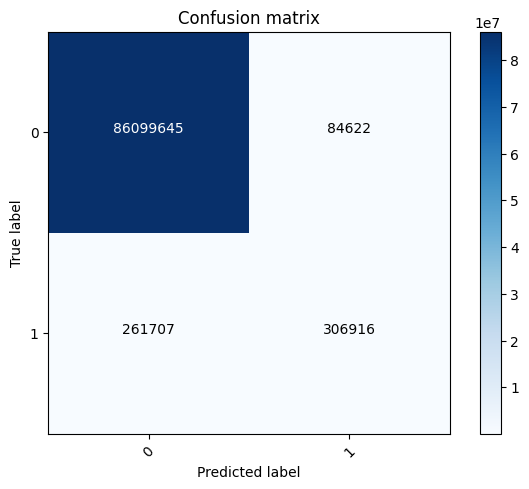

true vals to normalize [[86184267]
 [  568623]]
Normalized confusion matrix


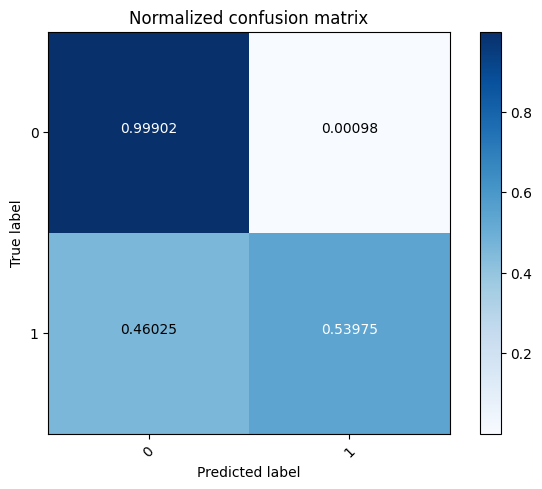

In [ ]:
plot_confusion_matrix(predicted_labels_list=predictions_flat, y_test_list=y_flat)